In [1]:
import itertools

from gabriel_lego import LEGOTask
from tqdm.notebook import tqdm

import edgedroid.data as e_data
from edgedroid.models import *
from generate_corr_sequence import gen_corr_sequence
import scipy.stats as st

model = EdgeDroidModel(
    frame_trace=e_data.load_default_trace("square00", truncate=5),
    frame_model=ZeroWaitSamplingPolicy.from_default_data(),
    timing_model=MultiCurveFittingExecutionTimeModel(neuroticism=1.0)
)

task = LEGOTask(e_data.load_default_task("square00", truncate=5))


acf_50 = 1 / (2 ** np.arange(5))  # 0.5 corr
acf_25 = 1 / (4 ** np.arange(5))
acf_12 = 1 / (8 ** np.arange(5))


def emulate_run(model: EdgeDroidModel, rtt_s_iter: Iterator[float], desc: str | None = None):
    # step_iter = tqdm(model.play_steps_emulated_time(), total=model.step_count + 1, desc=desc, leave=False)

    for model_step in model.play_steps_emulated_time():
        # in this setup, we have fixed rtts per step
        step_rtt = next(rtt_s_iter)

        frame_timings: Optional[FrameTimings] = None
        prev_frame: Optional[str] = None
        while True:
            try:
                model_frame = model_step.send(frame_timings)
            except StopIteration:
                if not prev_frame or prev_frame.lower() not in ("success", "initial"):
                    raise Exception(prev_frame)
                break

            # prev_result = task.submit_frame(model_frame.frame_data)
            prev_frame = model_frame.frame_tag
            frame_timings = FrameTimings(step_rtt * 0.9, step_rtt * 0.1)

delays  = gen_corr_sequence(
    dist_obj=st.lognorm(s=1.2, loc=0.1, scale=0.1),
    L=model.step_count + 1,
    target_acf=acf_50,
    debug=False,
)

emulate_run(model, iter(delays))
model.model_step_metrics()

,last_frame_rtt,execution_time,step_duration,time_to_feedback,wait_time,frame_count
step_number,,,,,,
0,0.108753,0.000000,0.108753,0.108753,0.000000,1
1,0.146505,4.990455,5.274187,0.283731,0.137226,36
2,0.157406,5.056783,5.351810,0.295027,0.137620,34
3,0.584516,5.060706,5.845158,0.784451,0.199936,10
4,0.326512,4.878873,5.224195,0.345322,0.018809,16
5,1.325219,4.746886,6.626094,1.879208,0.553989,5


In [4]:
import itertools as it
import multiprocess as mp

trace = "square00"
truncate = 50
reps_per_model = 30
rep_offset = 0

s_param = 1.2


class ThirdDegPolyExecutionTimeModel(MultiCurveFittingExecutionTimeModel):
    _fit_functions = (CubeFit,)


timing_frame_models = {
    "3rd-poly-high": lambda: (ThirdDegPolyExecutionTimeModel(neuroticism=1.0), ZeroWaitSamplingPolicy.from_default_data()),
    "3rd-poly-low": lambda:(ThirdDegPolyExecutionTimeModel(neuroticism=0.0), ZeroWaitSamplingPolicy.from_default_data()),
    "legacy": lambda: (LegacyModel(), LegacySamplingPolicy.from_default_data()),
    "first-order": lambda: (FirstOrderETM(), ZeroWaitSamplingPolicy.from_default_data()),
    "first-order-median": lambda: (FirstOrderAggregateETM(np.median), ZeroWaitSamplingPolicy.from_default_data())
}

min_bound = 0.042  # 24FPS

rhos = (
    (0.125, acf_12),
    (0.250, acf_25),
    (0.500, acf_50),
)

scales = (
    0.1,
    0.2,
    0.4,
    0.8,
    1.6,
    3.2,
)

def gen_delays(params):
    rep, (rho, acf_fn), scale = params
    delays = gen_corr_sequence(
        dist_obj=st.lognorm(s=s_param, loc=min_bound, scale=scale),
        L=truncate + 1,
        target_acf=acf_fn,
        debug=False,
    )
    return rep, rho, scale, delays

rho_scale_mapping = {}
p_iter = list(it.product(
    range(rep_offset, reps_per_model + rep_offset), rhos, scales,
))
delays_iter = iter(tqdm(p_iter, desc="Preparing delays..."))
with mp.Pool() as pool:
    for rep, rho, scale, delays in pool.imap_unordered(gen_delays, p_iter): 
        rho_scale_mapping[(rep, rho, scale)] = delays
        next(delays_iter)


for rep, (rho, acf_fn), scale in delays_iter:
    rho_scale_mapping[(rep, rho, scale)]  = gen_corr_sequence(
        dist_obj=st.lognorm(s=s_param, loc=min_bound, scale=scale),
        L=truncate + 1,
        target_acf=acf_fn,
        debug=False,
    )

dfs = deque()

params_iter = tqdm(list(it.product(
    timing_frame_models.items(),
    rho_scale_mapping.items()
)), desc="Parameter combinations")

for (model_name, model_policy_constructor), ((rep, rho, scale), delays) in params_iter:
    timing_model, sampling_policy = model_policy_constructor()
    
    model = EdgeDroidModel(
        frame_trace=e_data.load_default_trace(trace, truncate=truncate),
        frame_model=sampling_policy,
        timing_model=timing_model
    )
    
    emulate_run(model, iter(delays))

    df = model.model_step_metrics()
    df["model"] = model_name
    df["rep"] = rep
    df["s_param"] = s_param
    df["rho"] = rho
    df["scale"] = scale

    dfs.append(df)

data = pd.concat(dfs)
data.to_csv("./per_step_delay.csv")
data

Preparing delays...:   0%|          | 0/540 [00:00<?, ?it/s]

Parameter combinations:   0%|          | 0/2700 [00:00<?, ?it/s]

,last_frame_rtt,execution_time,step_duration,time_to_feedback,wait_time,frame_count,model,rep,s_param,rho,scale
step_number,,,,,,,,,,,
0,0.141671,0.000000,0.141671,0.141671,0.000000,1,3rd-poly-high,0,1.2,0.125,0.2
1,0.198346,5.003759,5.355339,0.351580,0.153235,27,3rd-poly-high,0,1.2,0.125,0.2
2,1.665303,5.079733,8.326514,3.246781,1.581478,5,3rd-poly-high,0,1.2,0.125,0.2
3,0.205733,5.698470,5.966246,0.267776,0.062044,29,3rd-poly-high,0,1.2,0.125,0.2
4,0.062924,5.051170,5.159757,0.108586,0.045662,82,3rd-poly-high,0,1.2,0.125,0.2
...,...,...,...,...,...,...,...,...,...,...,...
46,1.112496,5.230947,6.674978,1.444031,0.331535,6,first-order-median,29,1.2,0.500,1.6
47,1.482304,5.230947,7.411521,2.180574,0.698270,5,first-order-median,29,1.2,0.500,1.6
48,1.744638,5.230947,6.978554,1.747606,0.002968,4,first-order-median,29,1.2,0.500,1.6


In [6]:
data = pd.read_csv("per_step_delay.csv")
models = pd.CategoricalDtype(["3rd-poly-low", "3rd-poly-high", "legacy", "first-order", "first-order-median"],
                             ordered=False)
data["model"] = data["model"].astype(models)
# data = data[data["rho"] < 0.8]
# data = data[data["sigma"] < 3.2]

rho_scale_dtype = pd.CategoricalDtype(
    map(lambda t: f"{t[0]} {t[1]}", itertools.product(sorted(data["rho"].unique()), sorted(data["scale"].unique()))),
    ordered=True)

data["rho"] = data["rho"].astype("category")
data["scale"] = data["scale"].astype("category")

data["rho_scale"] = data[["rho", "scale"]].apply(func=lambda row: f"{row.rho} {row.scale}", axis=1).astype(
    rho_scale_dtype)
data



,step_number,last_frame_rtt,execution_time,step_duration,time_to_feedback,wait_time,frame_count,model,rep,s_param,rho,scale,rho_scale
0,0,0.141671,0.000000,0.141671,0.141671,0.000000,1,3rd-poly-high,0,1.2,0.125,0.2,0.125 0.2
1,1,0.198346,5.003759,5.355339,0.351580,0.153235,27,3rd-poly-high,0,1.2,0.125,0.2,0.125 0.2
2,2,1.665303,5.079733,8.326514,3.246781,1.581478,5,3rd-poly-high,0,1.2,0.125,0.2,0.125 0.2
3,3,0.205733,5.698470,5.966246,0.267776,0.062044,29,3rd-poly-high,0,1.2,0.125,0.2,0.125 0.2
4,4,0.062924,5.051170,5.159757,0.108586,0.045662,82,3rd-poly-high,0,1.2,0.125,0.2,0.125 0.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
137695,46,1.112496,5.230947,6.674978,1.444031,0.331535,6,first-order-median,29,1.2,0.500,1.6,0.5 1.6
137696,47,1.482304,5.230947,7.411521,2.180574,0.698270,5,first-order-median,29,1.2,0.500,1.6,0.5 1.6
137697,48,1.744638,5.230947,6.978554,1.747606,0.002968,4,first-order-median,29,1.2,0.500,1.6,0.5 1.6
137698,49,1.460552,5.230947,7.302759,2.071812,0.611260,5,first-order-median,29,1.2,0.500,1.6,0.5 1.6


In [7]:
total_durations = data.groupby(["model", "rep", "rho", "scale", "rho_scale"], observed=True)[
    "step_duration"].sum().reset_index()
total_durations

,model,rep,rho,scale,rho_scale,step_duration
0,3rd-poly-low,0,0.125,0.1,0.125 0.1,233.865012
1,3rd-poly-low,0,0.125,0.2,0.125 0.2,272.153985
2,3rd-poly-low,0,0.125,0.4,0.125 0.4,311.785431
3,3rd-poly-low,0,0.125,0.8,0.125 0.8,393.608002
4,3rd-poly-low,0,0.125,1.6,0.125 1.6,555.099160
...,...,...,...,...,...,...
2695,first-order-median,29,0.500,0.2,0.5 0.2,288.229276
2696,first-order-median,29,0.500,0.4,0.5 0.4,306.753687
2697,first-order-median,29,0.500,0.8,0.5 0.8,394.606985
2698,first-order-median,29,0.500,1.6,0.5 1.6,525.607481


mean duration


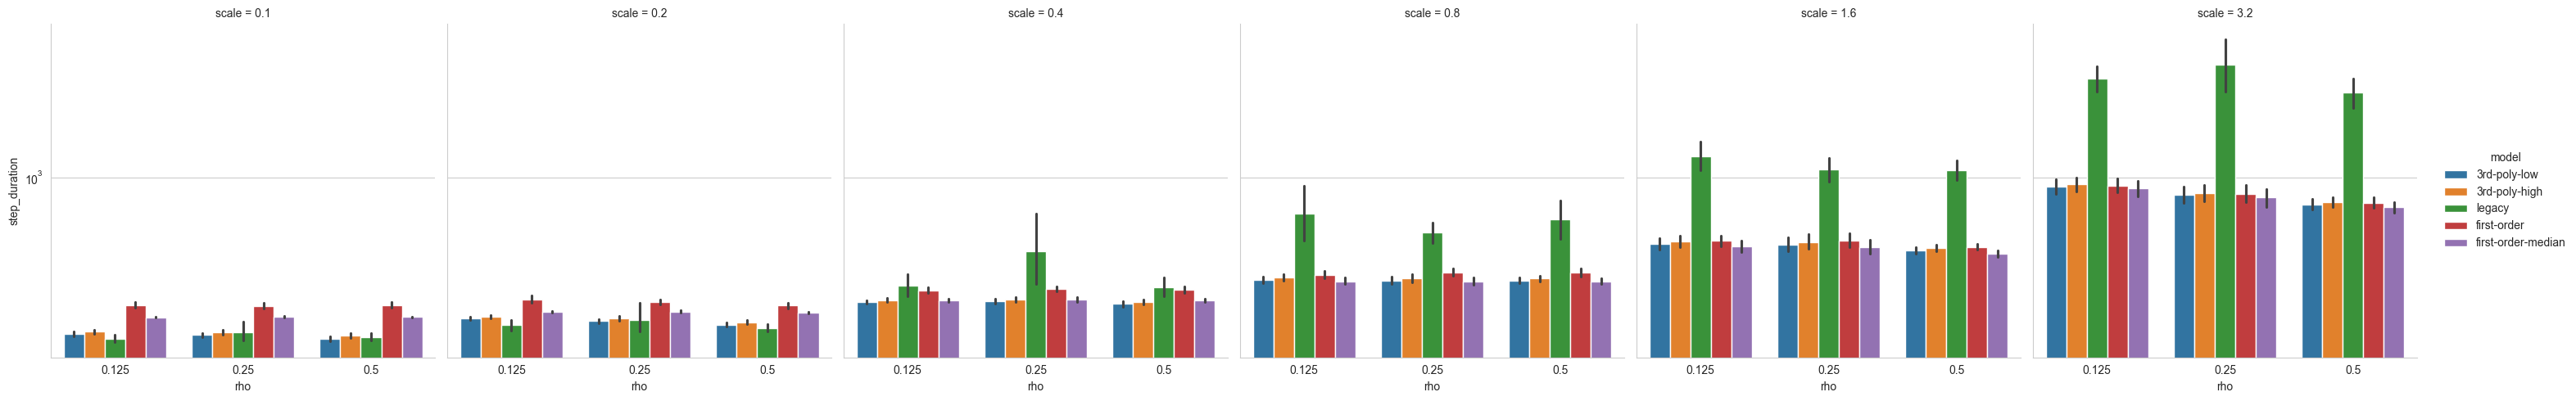

In [8]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

print("mean duration")
fg = sns.catplot(kind="bar", data=total_durations, hue="model", y="step_duration", col="scale", x="rho")
fg.set(yscale="log")
plt.show()

# push correlation higher

mean number of frames


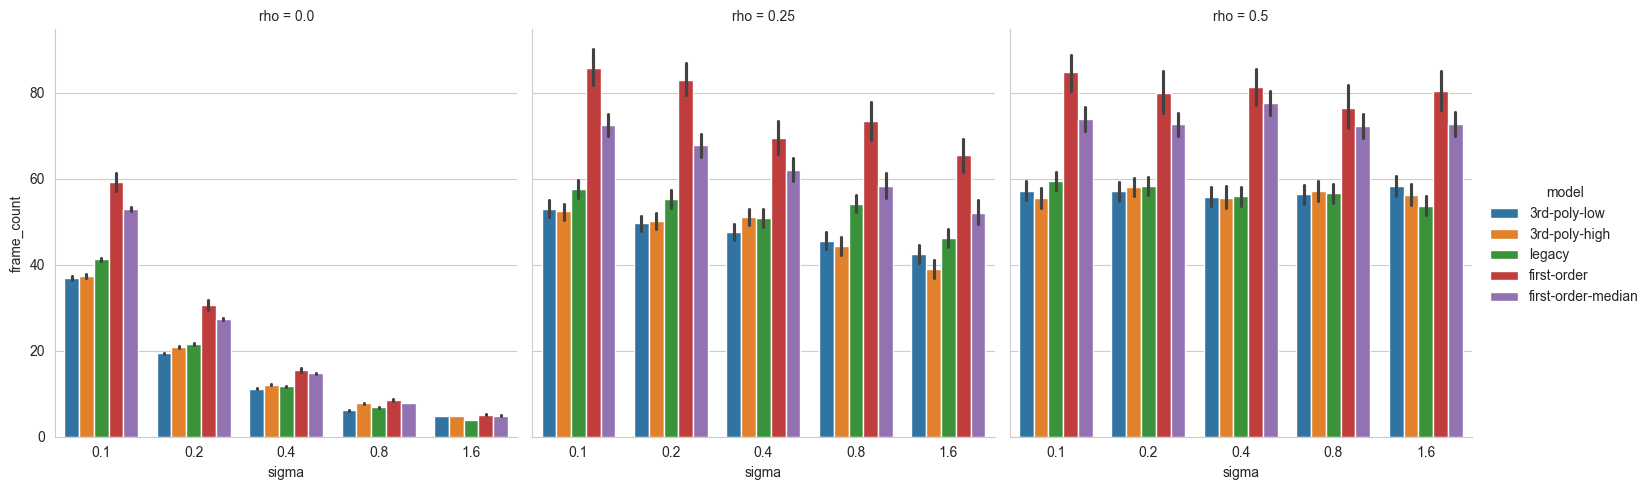

In [6]:
print("mean number of frames")
fg = sns.catplot(kind="bar", data=data, y="frame_count", hue="model", x="scale", col="rho")
plt.show()

mean TTF


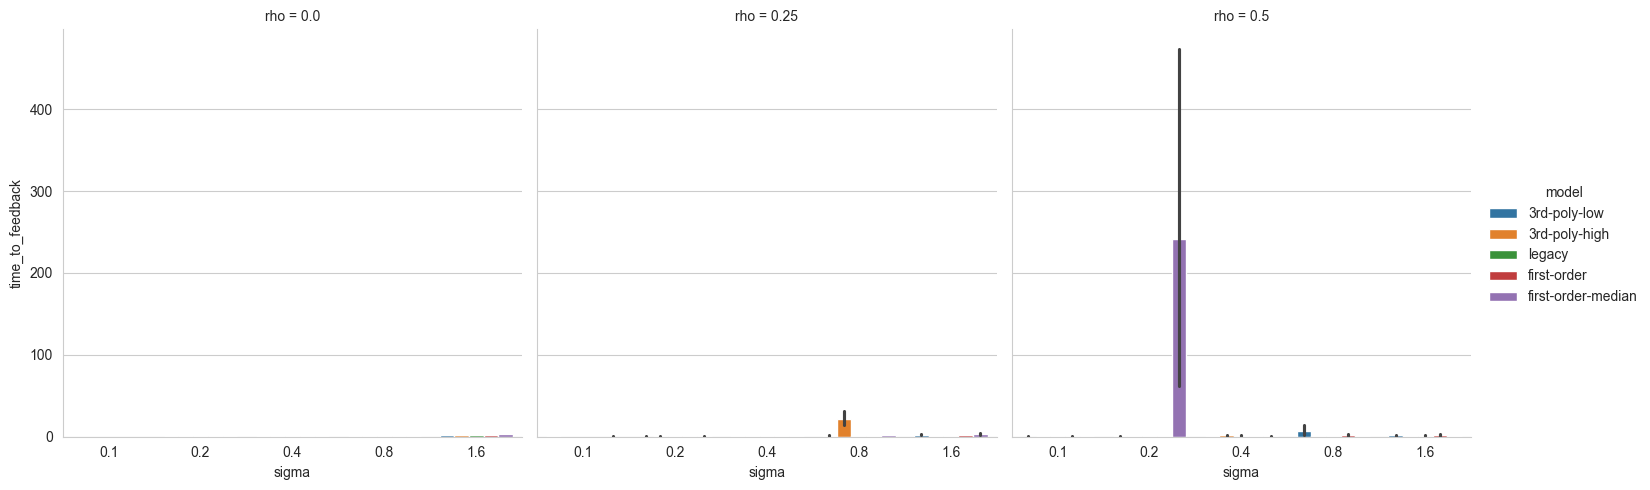

In [7]:
print("mean TTF")
fg = sns.catplot(kind="bar", data=data, hue="model", y="time_to_feedback", x="scale", col="rho")
plt.show()

mean wait time


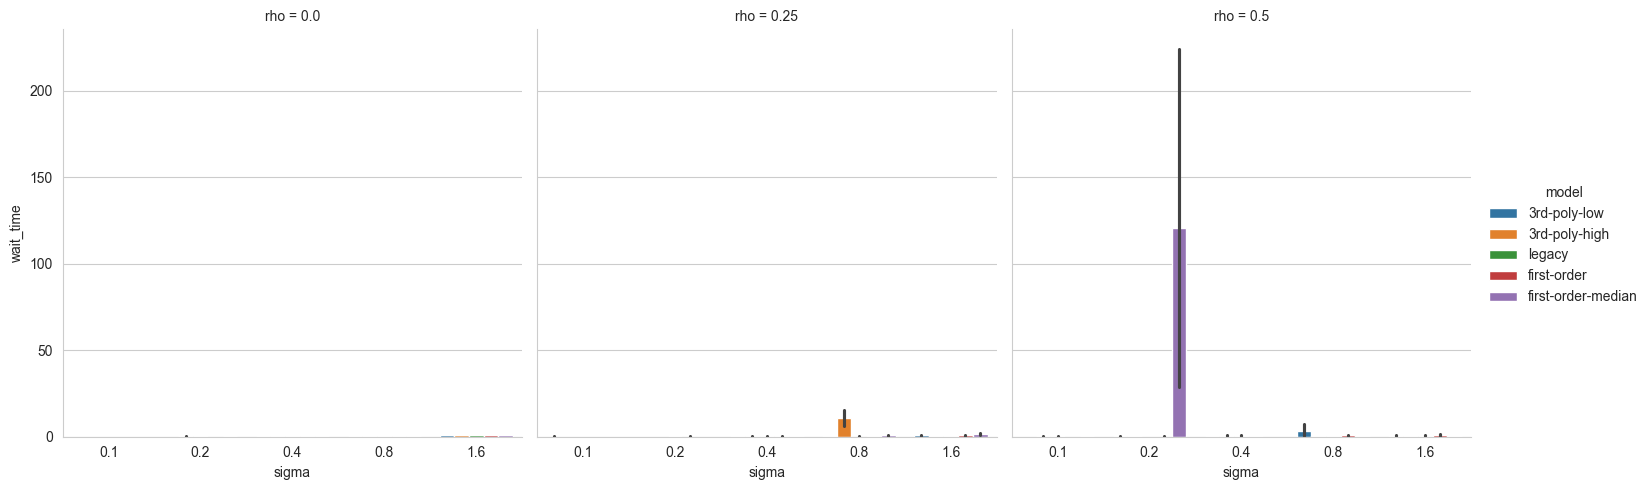

In [8]:
print("mean wait time")
fg = sns.catplot(kind="bar", data=data, hue="model", y="wait_time", x="scale", col="rho")
plt.show()

mean last frame rtt


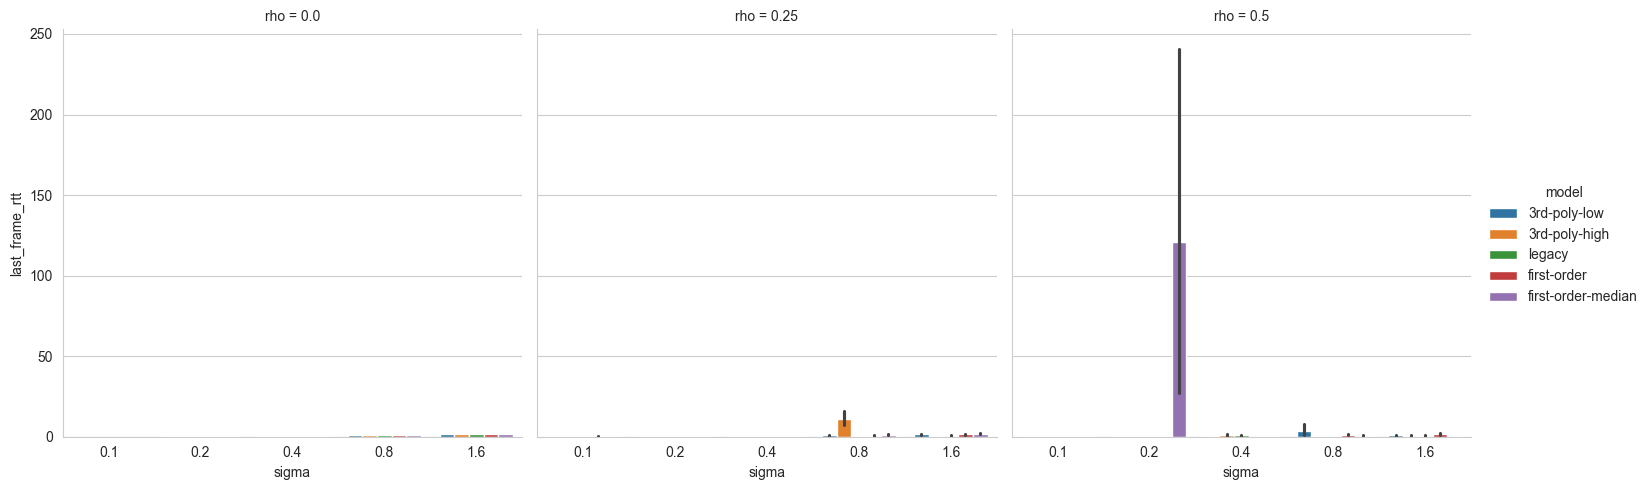

In [9]:
print("mean last frame rtt")
fg = sns.catplot(kind="bar", data=data, hue="model", y="last_frame_rtt", x="scale", col="rho")
plt.show()